

Build **kNN** and **logistic regression** classifiers using sklearn library to predict "passed" (label variable) by using given data. 
- Start the project with data processing such as converting non-numeric values to numerical ones,  data normalization, etc.
- Explore and analyze the data using feature visualization such as correlation heatmap, and distribution plots by commenting on your findings. Choose min. 3 features for the visualization step. 
- Then, shuffle and split your data into train and test sets randomly, with a ratio of 70:30. (Write your own shuffling and spliting code, do not use predefined function train_test_split).
- Build your models (with proper comments and explanations) using the training set.
- Compare these 2 classification models according to their accuracies (you can print accuracy values in a single table as a comprehensive view) over the test set. Comment on their classification performance.
- Plot confusion matrices for your models over the test set, and comment on the outcomes. 
- Finally, plot Precision-Recall (PR) curves for each classification model over the test set and evaluate/comment the prediction performance of each classifier. 

Notes:

* Choose the optimal k value using Minkowski distance (by trying two different p-values) for the kNN model.


* **Don't forget to add comments to your code lines to explain how your program works, and your intentions behind it. Also, do not forget to comment on the outcomes and comparisons.** 

In [47]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import random
from sklearn import neighbors
from sklearn.metrics import mean_squared_error , auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , precision_score,recall_score,precision_recall_curve , plot_precision_recall_curve

In [48]:
df = pd.read_csv("data.csv") 

df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


In [49]:
# Changing Categorical attributes to numerical.
df["school"].replace({"GP" , "MS"} , {0,1},inplace=True)
df["sex"].replace({"F","M"},{0,1},inplace=True)
df["address"].replace({"U","R"},{0,1} , inplace=True)
df["famsize"].replace({"LE3","GT3"},{0,1},inplace=True)
df["Pstatus"].replace({"T","A"},{1,0},inplace=True)

df.replace({"yes","no"},{1,0},inplace=True)


# we have to do one hot encoding for Mjob,Fjob,reason and guardian features.
dum_m = pd.get_dummies(df["Mjob"])
dum_f = pd.get_dummies(df["Fjob"])
dum_r = pd.get_dummies(df["reason"])
dum_g = pd.get_dummies(df["guardian"])

dum_parentsJob = dum_m + dum_f  # Sum their values to avoiding duplicate columns

# Drop original columns.
df.drop("Mjob",axis=1,inplace= True)
df.drop("Fjob",axis=1,inplace= True)
df.drop("reason",axis=1,inplace=True)
df.drop("guardian",axis=1,inplace=True)


df=pd.concat([df,dum_parentsJob,dum_r,dum_g],axis=1) # Add dummy variables to original dataframe.

# Other variables are numerical so we don't have to do any convertion to them.

# Scaling is done in split function.


df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,other,services,teacher,course,home,other,reputation,father,mother,other
0,0,0,18,0,1,0,4,4,2,2,...,0,0,1,1,0,0,0,0,1,0
1,0,0,17,0,1,1,1,1,1,2,...,1,0,0,1,0,0,0,1,0,0
2,0,0,15,0,0,1,1,1,1,2,...,1,0,0,0,0,1,0,0,1,0
3,0,0,15,0,1,1,4,2,1,3,...,0,1,0,0,1,0,0,0,1,0
4,0,0,16,0,1,1,3,3,1,2,...,2,0,0,0,1,0,0,1,0,0


<AxesSubplot: >

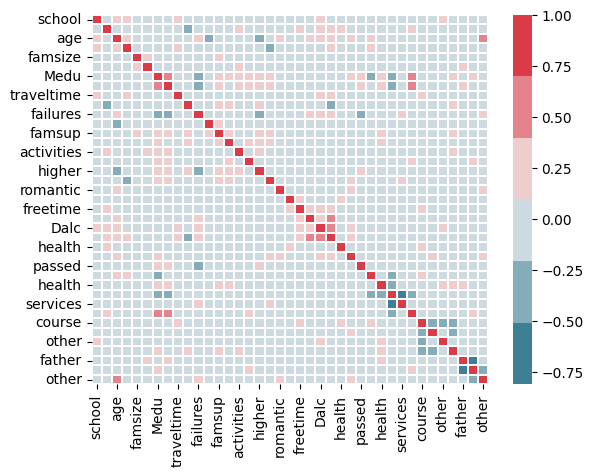

In [66]:
# Correlation Heatmap
corr = df.corr()

cmap = sns.diverging_palette(220,10) # Red squares represents positive, blue squares represents negative correlations.
sns.heatmap(corr,cmap=cmap,linewidths=0.25)


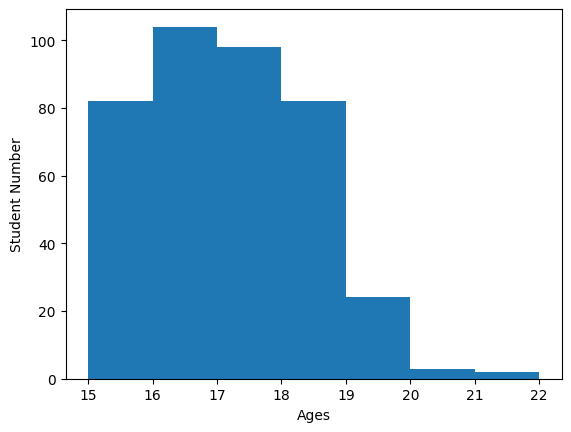

In [51]:
# Age distribution of students
plt.hist(df["age"],bins=(df["age"].max() - df["age"].min()))
plt.xlabel("Ages")
plt.ylabel("Student Number")
plt.show()

# Most of the students are in age between 15 and 19, we can say that this data obtained by mostly on high school students.

<BarContainer object of 5 artists>

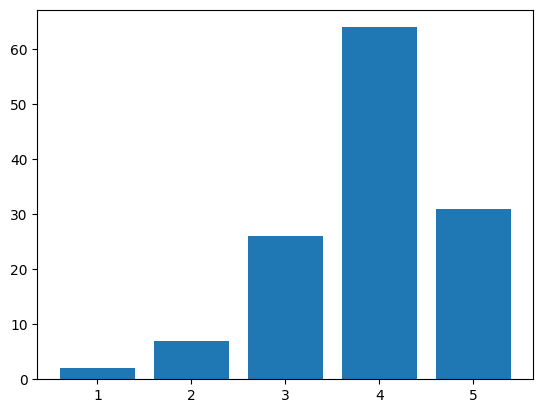

In [52]:
# Correlation between family relation and exam success.

df_failure = df[df["passed"] == 0]
relations_freq = df_failure["famrel"].sort_values().value_counts()
index = [4,5,3,2,1]

plt.bar(index,relations_freq)

# We can conclude that, family relationship and success in exam is not correlated.


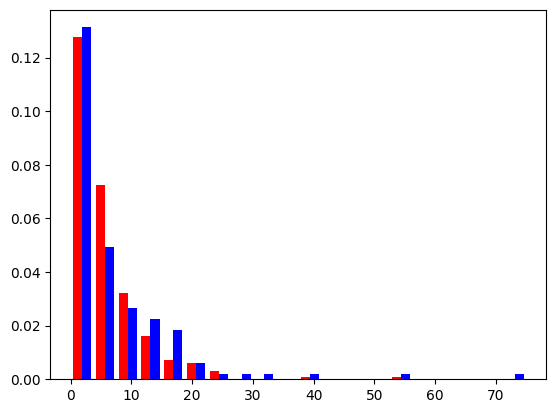

In [53]:
df_success = df[df["passed"] == 1]

plt.hist([df_success["absences"],df_failure["absences"]],bins = 20,color=["red","blue"],density=True) # red for succesfull students , blue for unsuccessfulls.

plt.show()

# We can say that attendance is not significantly relevant for success.

In [54]:

def shuffle(dataframe):
    rows = dataframe.to_numpy().tolist() # Convert rows to list.
    random.seed(0) ## To get comment on the performance of models, I have to get same randomness every time. Otherwise, performance of the models can change
    ## Shuffle the list of rows.
    for i in range(len(rows)):
        x = random.randint(0,len(rows)-1)
        val = rows.pop(x)
        rows.append(val)
    
    dataframe = pd.DataFrame(rows,columns= dataframe.columns) ## Creates new dataframe with shuffled rows.
    return dataframe



def split(dataframe,percent):
    # Find the length of train and test parts. 
    number_of_train  = int(dataframe.shape[0] * percent /100)
    number_of_test = dataframe.shape[0] - number_of_train

    # We get copy of original dataframe so original one can stay same.
    df_copy = dataframe.copy()
    df_copy = shuffle(df_copy)  # We shuffle copy dataframe to get random rows.
    
    y = df_copy["passed"].values ## All y values include only passed column
    df_copy.drop("passed",axis=1 , inplace=True) ## We drop passed column to get predictors.
    x = df_copy.values

    scaler = StandardScaler()
    scaler.fit(x)
    x_scale = scaler.transform(x)

    train_x = np.array(x_scale[:number_of_train])
    train_y = np.array(y[:number_of_train])
    test_x  = np.array(x_scale[number_of_train:])
    test_y = np.array(y[number_of_train:])
    

    return train_x,train_y,test_x,test_y 


train_x,train_y,test_x,test_y = split(df,70)




In [55]:

# We can select ideal k value from cross validation.

max_score_manh = 0
manh_k = 0 
for i in range(1,30,2):
    knn = neighbors.KNeighborsClassifier(i,metric="manhattan")
    score = cross_val_score(knn,train_x,train_y,cv = 10)
    if np.mean(score) >  max_score_manh:
        max_score_manh = np.mean(score)
        manh_k = i

   
max_score_euclidean = 0
euclidean_k = 0

for i in range(1,30,2):
    knn = neighbors.KNeighborsClassifier(i,metric="euclidean")
    score = cross_val_score(knn,train_x,train_y,cv = 10)
    if np.mean(score) >  max_score_euclidean:
        max_score_euclidean = np.mean(score)
        euclidean_k = i


print(f"Best score for manhattan distance: {max_score_manh} with k = {manh_k}")
print(f"Best score for euclidan distance: {max_score_euclidean} with k = {euclidean_k}")

# Euclidean distance is slightly better than manhattan distance.

Best score for manhattan distance: 0.6776455026455027 with k = 15
Best score for euclidan distance: 0.6812169312169313 with k = 23


Score of kNN classifier:  0.7058823529411765
Score of Logistic Regression Classifier:  0.6722689075630253




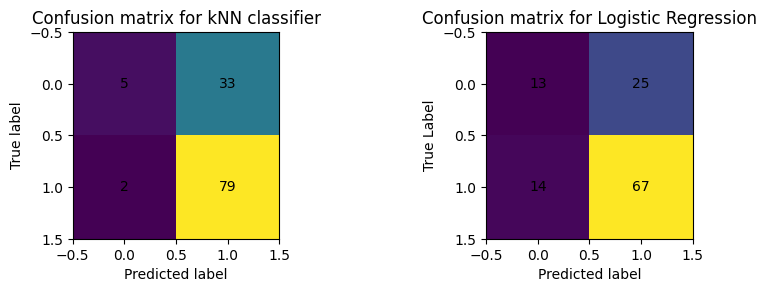

In [56]:
knnClassifier = neighbors.KNeighborsClassifier(euclidean_k,metric="euclidean")
LogisticReg = LogisticRegression()


knnClassifier.fit(train_x,train_y)
LogisticReg.fit(train_x,train_y)


knnClassifier_acc = knnClassifier.score(test_x,test_y)
LogisticReg_acc = LogisticReg.score(test_x,test_y)

print("Score of kNN classifier: ",knnClassifier_acc)
print("Score of Logistic Regression Classifier: ",LogisticReg_acc)
print("\n")

confusion_Knn = confusion_matrix(test_y, knnClassifier.predict(test_x))
confusion_log = confusion_matrix(test_y, LogisticReg.predict(test_x))

fig ,(ax1,ax2) = plt.subplots(1,2)

fig.set_size_inches(8,8)
ax1.imshow(confusion_Knn)
ax1.set_title("Confusion matrix for kNN classifier")
ax1.set_xlabel("Predicted label")
ax1.set_ylabel("True label")

for i in range(2):
    for j in range(2):
        ax1.text(j,i,confusion_Knn[i][j], ha="center",va="center")



ax2.imshow(confusion_log)
ax2.set_title("Confusion matrix for Logistic Regression")
ax2.set_xlabel("Predicted label")
ax2.set_ylabel("True Label")
for i in range(2):
    for j in range(2):
        ax2.text(j,i,confusion_log[i][j], ha="center",va="center")

plt.subplots_adjust(wspace=1)
plt.show()


# Accuracy of kNN model is higher than logistic regression model. If we look for precision. logistic model is better. In recall, kNN is better. For the false positive rate, knn model is better. In true positive rate, logistic model is better. 

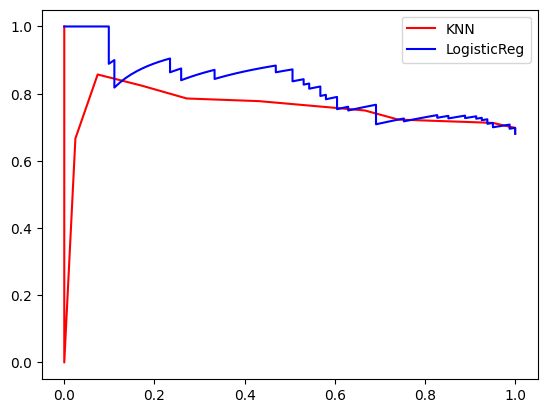

Precision-Recall score for kNN:  0.753
Precision-Recall score for Logistic Regression:  0.821


In [57]:


# Getting probabilities of predictions.
pred_knn = knnClassifier.predict_proba(test_x)[:,1] # Transforming probabilities to 1D array.

pred_logistic = LogisticReg.predict_proba(test_x)[:,1]



precisionK,recallK,thresholdsK = precision_recall_curve(test_y,pred_knn)
precisionL,recallL,thresholdsL = precision_recall_curve(test_y,pred_logistic)


plt.plot(recallK,precisionK,color="red",label="KNN")
plt.plot(recallL,precisionL,color="blue",label="LogisticReg")

plt.legend()
plt.show()

auc_knn = auc(recallK,precisionK)
auc_logistic = auc(recallL,precisionL)

print("Precision-Recall score for kNN: " , round(auc_knn,3))
print("Precision-Recall score for Logistic Regression: " , round(auc_logistic,3))


# Thresholds for knn classification is lower than logistic regression model, because of that line of knn Model has less details, so it is hard to say one model is better than other.
